In [1]:
from utils.setup_utils import setup
setup(globals())

W, B = load_model()
x, y = load_data()

x = (x - 0.1307) / 0.3081
x = x.reshape(-1, 28 * 28)

def ginit(shape):
    return np.zeros(shape, dtype=gp.Var)

In [41]:
def generate_adversarial_input(index, fake_label):
    true_label = y[index]
    image = x[index]
    
    m = gp.Model()

    gurobi_x = [ginit(x.shape[1]), ginit(B[0].shape), ginit(B[1].shape), ginit(B[2].shape)]
    gurobi_z = [None, ginit(B[0].shape), ginit(B[1].shape), ginit(B[2].shape)]


    for j in range(x.shape[1]):
        gurobi_x[0][j] = m.addVar(vtype='C', name=f'x_0_{j}') 
    #                               lb=(-1 - 0.1307) / 0.3081, ub=(1 - 0.1307) / 0.3081)

    for layer_index in range(3):
        w = W[layer_index]
        b = B[layer_index]

        n_k_prev, n_k = w.shape

        for j in range(n_k):
            gurobi_x[layer_index + 1][j] = m.addVar(vtype='C', name=f'x_{layer_index}_{j}')
            gurobi_z[layer_index + 1][j] = m.addVar(vtype='C', name=f'z_{layer_index}_{j}')

    for layer_index in range(3):
        w = W[layer_index]
        b = B[layer_index]

        n_k_prev, n_k = w.shape

        for j in range(n_k):

            _ = m.addConstr(gp.quicksum(w[i][j] * gurobi_x[layer_index][i] 
                                     for i in range(n_k_prev)) \
                            + b[j] == gurobi_z[layer_index + 1][j])

            _ = m.addConstr(gurobi_x[layer_index + 1][j] == \
                            gp.max_([gurobi_z[layer_index + 1][j], 0]))

    _ = m.addConstr(gurobi_x[-1][fake_label] == gp.max_(gurobi_x[-1][i] for i in range(10)))

    delta = ginit(image.shape[0])

    for j in range(image.shape[0]):
        delta[j] = m.addVar(vtype='C', name=f'delta_{j}')
        _ = m.addConstr((gurobi_x[0][j] - image[j]) == delta[j])

    m.setObjective(gp.quicksum(delta[i] ** 2 for i in range(image.shape[0])), gp.GRB.MINIMIZE)

    m.optimize()
    
    constructed = np.array([gurobi_x[0][j].X for j in range(image.shape[0])]).reshape(28, 28)
    scaled_back = (constructed * 0.3081) + 0.1307
    final = np.uint8((scaled_back * 255).clip(0, 255))
    return scaled_back # final

In [42]:
results = list()
for index in tqdm(np.arange(5), leave=False):
    for fake_label in tqdm(np.arange(10), leave=False):
        o = generate_adversarial_input(index, fake_label)
        results.append({
            'index':index,
            'fake_label':fake_label,
            'constructed':o
        })

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
# import pickle

# with open('adv_results.pickle', 'wb') as handle:
#     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# with open('adv_results.pickle', 'rb') as handle:
#     b = pickle.load(handle)

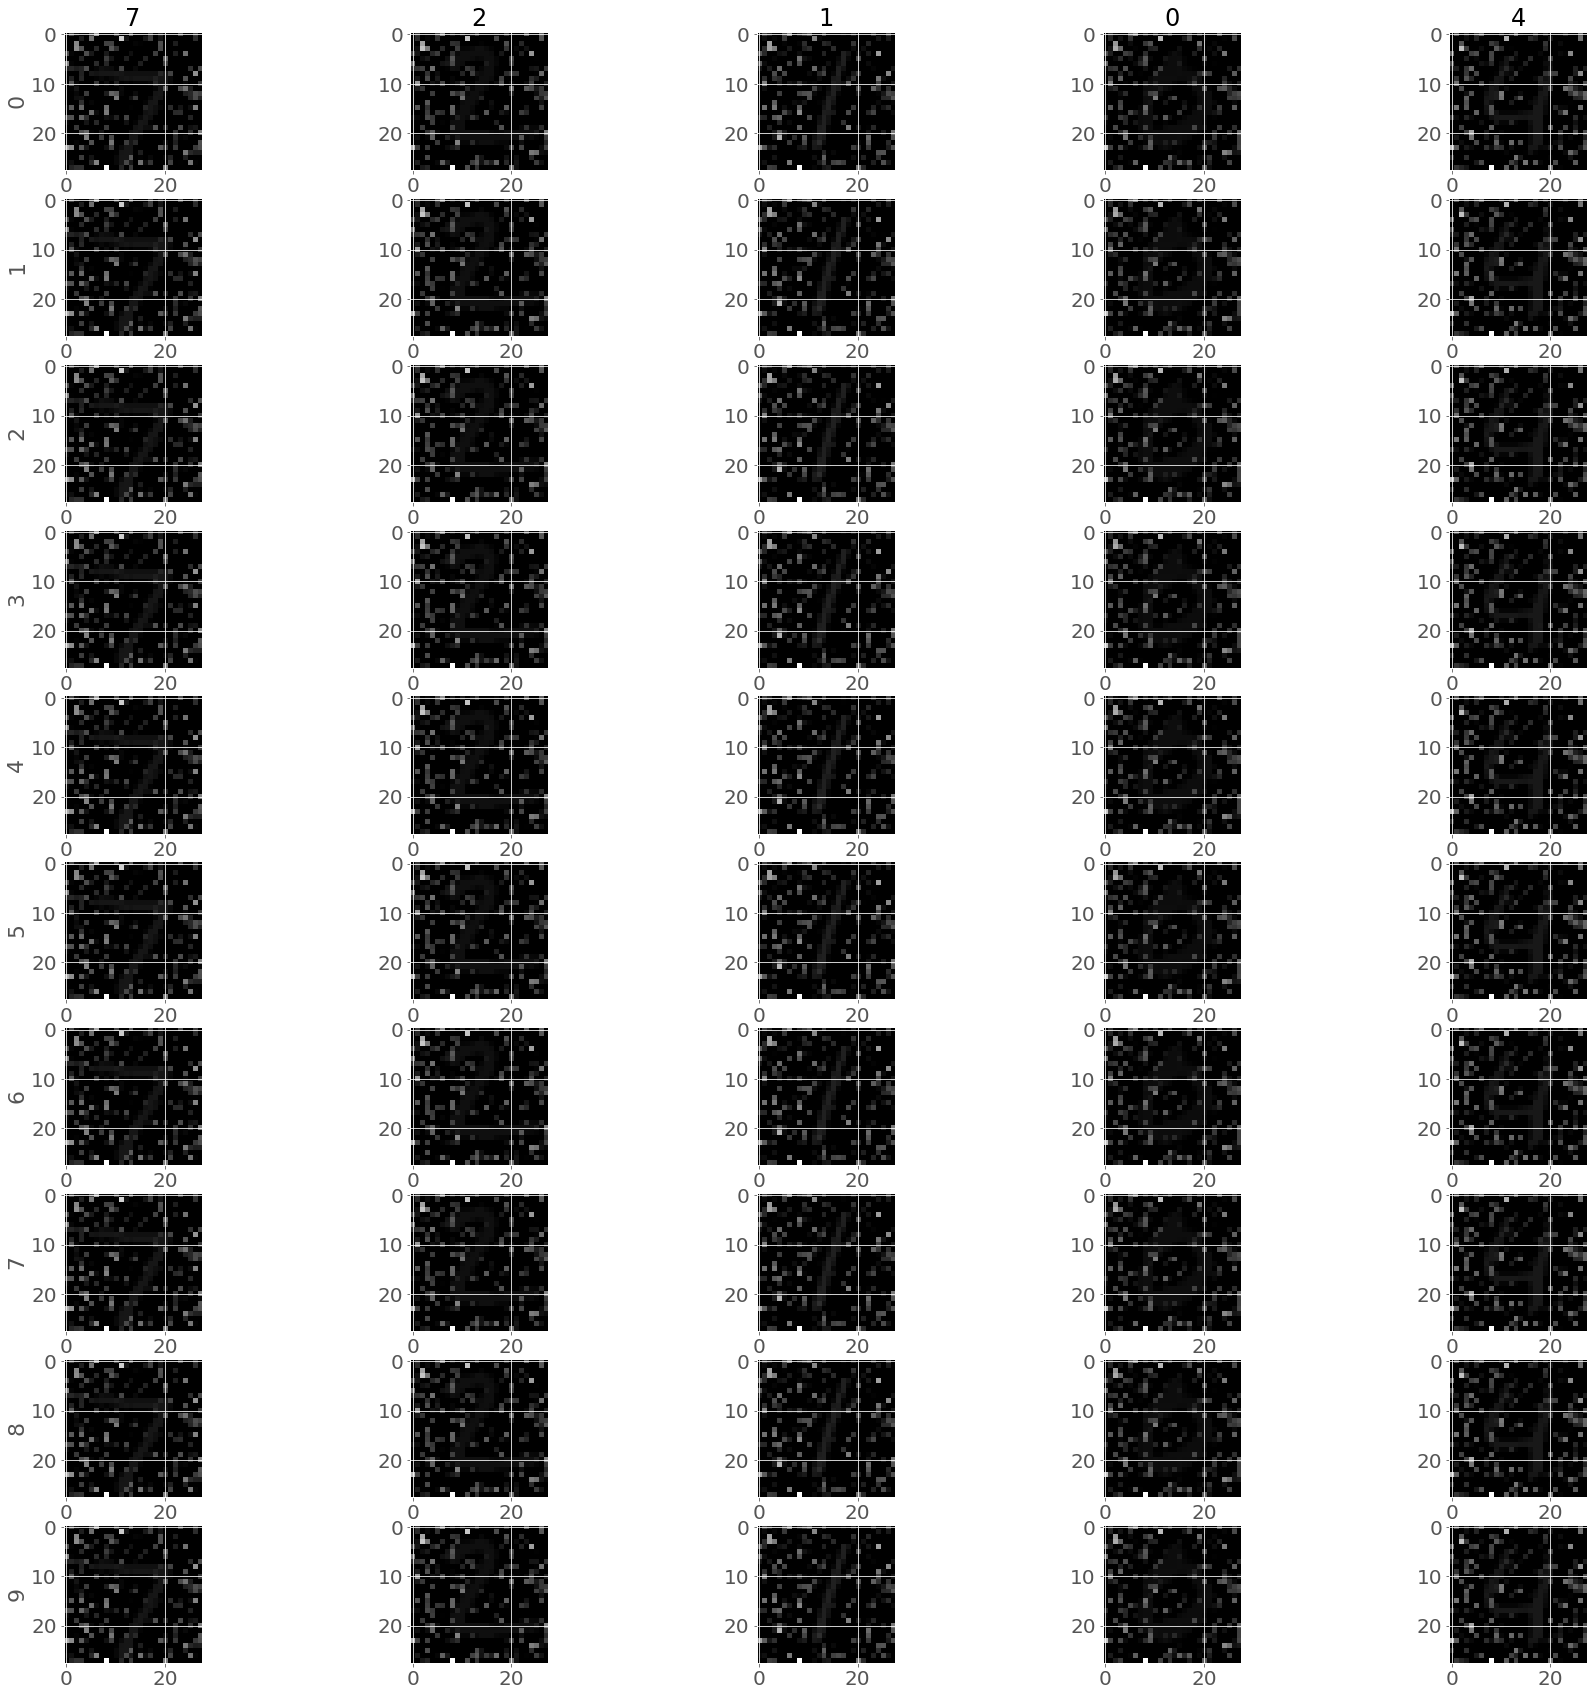

In [44]:
fig, ax = plt.subplots(10, 5, figsize=(30, 30))    

for r in results:
    index = r['index']
    fake_label = r['fake_label']
    constructed = r['constructed']
    image = x[index].reshape(28, 28)
    true_label = y[index]
    
    if fake_label == 0:
        _ = ax[0, index].set_title(true_label)
    
    if index == 0:
        _ = ax[fake_label, 0].set_ylabel(fake_label)
    
    _ = ax[fake_label, index].imshow(constructed, cmap='gray')

fig.savefig('examples.png')

In [45]:
def feed_forward(raw_image):
    im = raw_image.reshape(28 * 28) / 255
    im = (im - 0.1307) / 0.3081
    x1 = im.reshape(-1, 28 * 28) @ W[0] + B[0]
    y1 = relu(x1)

    x2 = y1 @ W[1] + B[1]
    y2 = relu(x2)

    x3 = y2 @ W[2] + B[2]

    return x3.argmax(axis=1)

In [46]:
test = list()

for r in tqdm(results):
    index = r['index']
    fake_label = r['fake_label']
    constructed = r['constructed']
    image = x[index].reshape(28, 28)
    true_label = y[index]
    
    nn_result = feed_forward(constructed)[0]
    test.append({'index':index, 'fake_label':fake_label, 
                 'true_label':true_label, 'nn_label':nn_result})

  0%|          | 0/50 [00:00<?, ?it/s]

In [47]:
(df.true_label == df.nn_label).mean()

0.85

In [48]:
(df.fake_label == df.nn_label).mean()

0.12